### Переходим к практике

In [276]:
import pandas as pd

In [277]:
import warnings
warnings.filterwarnings('ignore')

Наши новости

In [278]:
news = pd.read_csv(r"C:\Users\Olga\Documents\ITClass\ML_in_business\Lessons\lection2_materials\articles.csv")

In [279]:
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [280]:
users = pd.read_csv(r"C:\Users\Olga\Documents\ITClass\ML_in_business\Lessons\lection2_materials\users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [281]:
#!pip install gensim

In [282]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [283]:
#!pip install razdel

In [284]:
#!pip install pymorphy2

In [285]:
#!pip install nltk

In [286]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel


import pymorphy2  # pip install pymorphy2

In [287]:
import nltk
#nltk.download('stopwords')

In [288]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [289]:
with open(r'C:\Users\Olga\Documents\ITClass\ML_in_business\Lessons\lection2_materials\stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [290]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [291]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 45.6 s


In [292]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 7min 4s


А теперь в 3 строчки обучим нашу модель

In [293]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [294]:
common_dictionary[45]

'орган'

Все просто - это словарь наших слов

Запускаем обучение

In [295]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 1min 29s


In [296]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [297]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.059295885), (17, 0.920109)]

In [298]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: налог лодка год джон куба платёжный седьмой
topic_1: это который мочь всё говорить свой наш
topic_2: статья который россия рубль экономический население nn
topic_3: проект компания год тыс программа млн цена
topic_4: газ остров рак сигнал поток памятник восток
topic_5: рейтинг место балл занять строчка занимать третий
topic_6: украина россия nn украинский российский киев белоруссия
topic_7: военный который страна американский это сша российский
topic_8: год исследование это который ракета млн земля
topic_9: департамент реконструкция звёздный приток праздничный транспорт мэрия
topic_10: суд дело ребёнок банк женщина гражданин сотрудник
topic_11: погибнуть дональд дыра мальчик вследствие калифорния вероятно
topic_12: млрд год фонд который компания это эксперимент
topic_13: год это президент глава министр российский россия
topic_14: болезнь высота парламент рекомендовать ночью день предмет
topic_15: температура космос градус бизнесмен сон погода билет
topic_16: автор египет nn ст

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [299]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [300]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.00000,0.028672,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.065336,0.073369,0.000000
1,4896,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.472058,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.504906
2,4897,0.05924,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.920165,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,4898,0.00000,0.247136,0.225425,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.074009,0.443375,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,4899,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.086086


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [301]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [302]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [303]:
doc_dict[293622]

array([0.01897733, 0.        , 0.22682132, 0.15655617, 0.        ,
       0.        , 0.        , 0.26781133, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05113585, 0.        ,
       0.        , 0.08274879, 0.18501887, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [304]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [305]:
get_user_embedding(user_articles_list)

array([0.        , 0.10801061, 0.10618637, 0.        , 0.        ,
       0.        , 0.0980226 , 0.08430597, 0.03019675, 0.        ,
       0.06153539, 0.        , 0.00890089, 0.17546033, 0.03152746,
       0.        , 0.00338108, 0.11418113, 0.        , 0.05737514,
       0.05970711, 0.        , 0.01300961, 0.0040367 , 0.0292452 ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [306]:
#users['articles'].iloc[33]

In [307]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [404]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.003163,0.000000,0.081296,0.094240,0.010689,0.0,0.091173,0.115776,0.081494,...,0.011061,0.071290,0.104429,0.055020,0.097646,0.000000,0.0,0.000000,0.000000,0.019844
1,u108690,0.000000,0.182454,0.102984,0.036317,0.000000,0.0,0.114100,0.093257,0.018407,...,0.000000,0.000000,0.092101,0.014359,0.086027,0.074114,0.0,0.000000,0.006789,0.023732
2,u108339,0.006230,0.011375,0.069342,0.003434,0.007377,0.0,0.020051,0.096374,0.046037,...,0.003906,0.002459,0.074997,0.034331,0.212961,0.078679,0.0,0.003493,0.000000,0.020275


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [405]:
target = pd.read_csv(r"C:\Users\Olga\Documents\ITClass\ML_in_business\Lessons\lection2_materials\users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [406]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.003163,0.000000,0.081296,0.094240,0.010689,0.0,0.091173,0.115776,0.081494,...,0.071290,0.104429,0.055020,0.097646,0.000000,0.0,0.000000,0.000000,0.019844,0
1,u108690,0.000000,0.182454,0.102984,0.036317,0.000000,0.0,0.114100,0.093257,0.018407,...,0.000000,0.092101,0.014359,0.086027,0.074114,0.0,0.000000,0.006789,0.023732,1
2,u108339,0.006230,0.011375,0.069342,0.003434,0.007377,0.0,0.020051,0.096374,0.046037,...,0.002459,0.074997,0.034331,0.212961,0.078679,0.0,0.003493,0.000000,0.020275,1


In [407]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [408]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [409]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [410]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.06951384, 0.01963675, 0.50205518, 0.19057941, 0.01892432,
       0.05848485, 0.1204801 , 0.13422346, 0.11444601, 0.24957269])

In [411]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [412]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.284662, F-Score=0.715, Precision=0.704, Recall=0.727


In [413]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [414]:
import itertools  

Confusion matrix, without normalization
[[1680   75]
 [  68  177]]


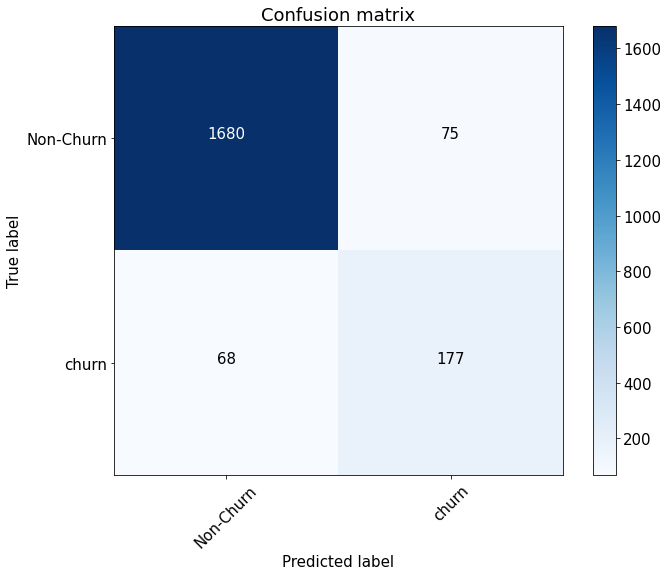

In [415]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig(r"C:\Users\Olga\Documents\ITClass\ML_in_business\Lessons\lection2_materials\conf_matrix.png")
plt.show()

In [416]:
roc_auc_score(y_test, preds)

0.9596418396418397

In [417]:
roc_auc = roc_auc_score(y_test, preds)

5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [418]:
df = pd.DataFrame(columns=['model', 'roc_auc', 'precision', 'recall', 'f_score'])
df

,model,roc_auc,precision,recall,f_score


In [419]:
df = df.append({'model': 'mean', 'roc_auc': roc_auc, 'precision': precision[ix], 'recall': recall[ix], 'f_score': fscore[ix]}, ignore_index=True)
df

,model,roc_auc,precision,recall,f_score
0,mean,0.959642,0.703557,0.726531,0.714859


В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [420]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [421]:
get_user_embedding_median(user_articles_list)

array([0.        , 0.07707783, 0.02547297, 0.        , 0.        ,
       0.        , 0.04804719, 0.03694377, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.19592482, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03276029, 0.        , 0.        , 0.        , 0.        ])

In [422]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.000000,0.000000,0.0,0.0,0.0,0.044329,0.045863,0.000000,...,0.0,0.0,0.139334,0.014862,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,u108690,0.0,0.171088,0.099955,0.0,0.0,0.0,0.138163,0.085273,0.012478,...,0.0,0.0,0.092786,0.000000,0.041697,0.064589,0.0,0.0,0.0,0.013862
2,u108339,0.0,0.000000,0.068633,0.0,0.0,0.0,0.000000,0.057007,0.038457,...,0.0,0.0,0.078145,0.029655,0.202547,0.038326,0.0,0.0,0.0,0.023465


In [423]:
target = pd.read_csv(r"C:\Users\Olga\Documents\ITClass\ML_in_business\Lessons\lection2_materials\users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [424]:
X = pd.merge(user_embeddings_median, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.000000,0.000000,0.0,0.0,0.0,0.044329,0.045863,0.000000,...,0.0,0.139334,0.014862,0.000000,0.000000,0.0,0.0,0.0,0.000000,0
1,u108690,0.0,0.171088,0.099955,0.0,0.0,0.0,0.138163,0.085273,0.012478,...,0.0,0.092786,0.000000,0.041697,0.064589,0.0,0.0,0.0,0.013862,1
2,u108339,0.0,0.000000,0.068633,0.0,0.0,0.0,0.000000,0.057007,0.038457,...,0.0,0.078145,0.029655,0.202547,0.038326,0.0,0.0,0.0,0.023465,1


In [425]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [426]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [427]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.05616131, 0.04515617, 0.38786127, 0.25113515, 0.04094918,
       0.06186704, 0.13664538, 0.13894764, 0.17067833, 0.28193758])

In [428]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.276662, F-Score=0.764, Precision=0.721, Recall=0.812


Confusion matrix, without normalization
[[1678   77]
 [  47  198]]


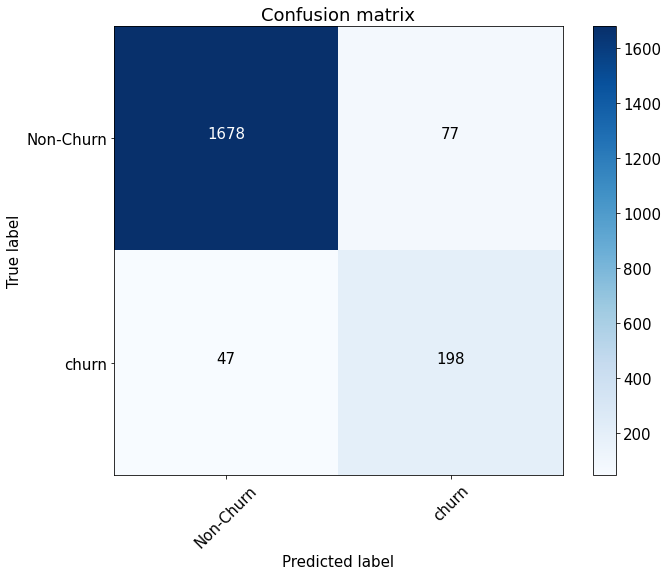

In [429]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig(r"C:\Users\Olga\Documents\ITClass\ML_in_business\Lessons\lection2_materials\conf_matrix.png")
plt.show()

In [430]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9699005756148614

In [431]:
df = df.append({'model': 'median', 'roc_auc': roc_auc_median, 'precision': precision[ix], 'recall': recall[ix], 'f_score': fscore[ix]}, ignore_index=True)
df

,model,roc_auc,precision,recall,f_score
0,mean,0.959642,0.703557,0.726531,0.714859
1,median,0.957602,0.721014,0.812245,0.763916


3. Повторить п.2, но используя уже не медиану, а max

In [432]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [433]:
get_user_embedding_max(user_articles_list)

array([0.        , 0.310509  , 0.44857526, 0.        , 0.        ,
       0.        , 0.34808043, 0.24390793, 0.15672685, 0.        ,
       0.34887031, 0.        , 0.03222982, 0.36003432, 0.14107956,
       0.        , 0.02028648, 0.58204603, 0.        , 0.29142815,
       0.22372042, 0.        , 0.07805763, 0.02422021, 0.17547122])

In [434]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.018977,0.000000,0.260954,0.408885,0.064132,0.0,0.264022,0.335119,0.390243,...,0.066368,0.344990,0.185019,0.216654,0.298361,0.000000,0.0,0.000000,0.000000,0.073504
1,u108690,0.000000,0.388610,0.217005,0.179620,0.000000,0.0,0.184680,0.226392,0.057190,...,0.000000,0.000000,0.149470,0.086151,0.267226,0.219534,0.0,0.000000,0.040735,0.084455
2,u108339,0.037383,0.038176,0.139439,0.020604,0.044263,0.0,0.067524,0.349397,0.116326,...,0.023433,0.014755,0.142534,0.086052,0.454622,0.287101,0.0,0.020956,0.000000,0.040545


In [435]:
target = pd.read_csv(r"C:\Users\Olga\Documents\ITClass\ML_in_business\Lessons\lection2_materials\users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [436]:
X = pd.merge(user_embeddings_max, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.018977,0.000000,0.260954,0.408885,0.064132,0.0,0.264022,0.335119,0.390243,...,0.344990,0.185019,0.216654,0.298361,0.000000,0.0,0.000000,0.000000,0.073504,0
1,u108690,0.000000,0.388610,0.217005,0.179620,0.000000,0.0,0.184680,0.226392,0.057190,...,0.000000,0.149470,0.086151,0.267226,0.219534,0.0,0.000000,0.040735,0.084455,1
2,u108339,0.037383,0.038176,0.139439,0.020604,0.044263,0.0,0.067524,0.349397,0.116326,...,0.014755,0.142534,0.086052,0.454622,0.287101,0.0,0.020956,0.000000,0.040545,1


In [437]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [438]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [439]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.02225424, 0.00522508, 0.80032127, 0.4326158 , 0.00190934,
       0.02064074, 0.16744556, 0.00294559, 0.01565185, 0.35415551])

In [440]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.366561, F-Score=0.835, Precision=0.825, Recall=0.845


Confusion matrix, without normalization
[[1711   44]
 [  39  206]]


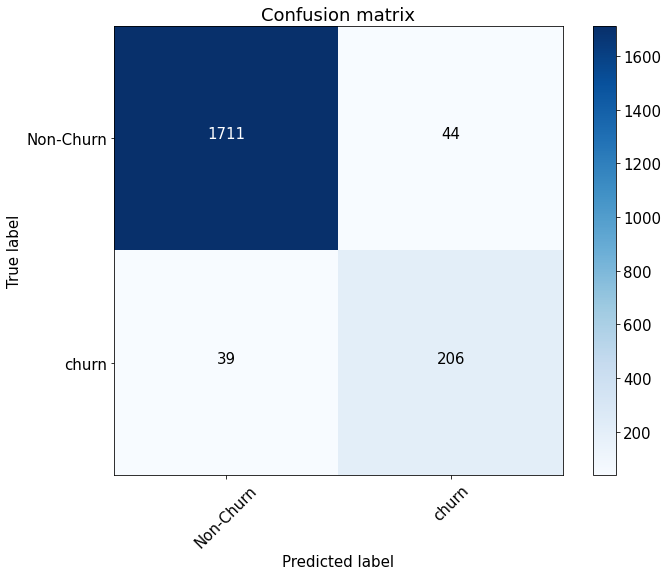

In [441]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig(r"C:\Users\Olga\Documents\ITClass\ML_in_business\Lessons\lection2_materials\conf_matrix.png")
plt.show()

In [442]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9808686551543695

In [443]:
df = df.append({'model': 'max', 'roc_auc': roc_auc, 'precision': precision[ix], 'recall': recall[ix], 'f_score': fscore[ix]}, ignore_index=True)
df

,model,roc_auc,precision,recall,f_score
0,mean,0.959642,0.703557,0.726531,0.714859
1,median,0.957602,0.721014,0.812245,0.763916
2,max,0.980869,0.824701,0.844898,0.834677
